# Predictive Maintenance Sample

### Import Libraries
First we want to import all the libraries that we will be needing. They are grouped by their functionality.

In [ ]:
# load and plot dataset
import pandas as pd #handles loading and editing data
from matplotlib import pyplot #handles plotting data

#Mathematical Operations
from sklearn.metrics import mean_squared_error #a computation of error through averaging the squared error
from sklearn.preprocessing import MinMaxScaler #Handles scaling between a and b

#Models
from sklearn.naive_bayes import GaussianNB #This is the naive bayes model we will use in part 1
from keras.models import Sequential #neural network for a sequence of layers
from keras.layers import Dense #Standard neural network layer
from keras.layers import Activation #Non-linear functions in the neural network to make it non-linear.
from keras.layers import Dropout #After a layer it drops a percentage of data to prevent overfitting on the training data.

#we will use this to add random error to try to detect anomalies
import random

#we will use this to split train and test data
from sklearn.model_selection import train_test_split

import numpy as np

%matplotlib inline

### Setting Random Seed
We set the seed to get reproducible results.

In [ ]:
np.random.seed(7)
from tensorflow import set_random_seed
set_random_seed(2)

### Loading Data
1. We will use pandas, imported as pd, to read the csv, maintenance_data.csv.

2. Because our input data has string values, we want to convert these string values into integers so they can be used in the machine learning algorithm. We use the .map function to change "TeamA" to 0, "TeamB" to 1, and "TeamC" to 2.

3. We will do the same for provider.

4. We return df.head(5) to show the first 5 rows of our dataset after changing to numerical values.

In [2]:
df = pd.read_csv('maintenance_data.csv')
# changing team values to numerical values
team_map = {"TeamA" : 0, "TeamB" : 1, "TeamC" : 2}
df['team'] = df['team'].map(team_map)

# changing provider values to numerical values
provider_map = {"Provider1" : 0, "Provider2" : 1, "Provider3" : 2, "Provider4" : 3}
df['provider'] = df['provider'].map(provider_map)

df.head(5)

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,0,3
1,81,1,72.075938,103.065701,87.271062,2,3
2,60,0,96.272254,77.801376,112.196170,0,0
3,86,1,94.406461,108.493608,72.025374,2,1
4,34,0,97.752899,99.413492,103.756271,1,0


### Editing Table
1. We do not want any null values in our table, so we check if there are any.
2. Then we plot the correlation between our external factors. Red means high correlation while blue means low correlation. We want low correlation because if we have multiple columns with high correlation, it's repetitive in the machine learning model. 

In [3]:
df.isnull().values.any()

False

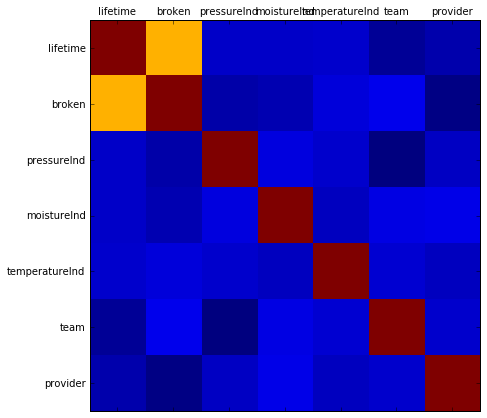

In [4]:
def plot_corr(df, size=7):
    corr = df.corr() 
    fig, ax = pyplot.subplots(figsize=(size, size))
    ax.matshow(corr)
    pyplot.xticks(range(len(corr.columns)), corr.columns)
    pyplot.yticks(range(len(corr.columns)), corr.columns)
    
plot_corr(df)

### Deleting Columns
We can delete columns by using del command. del df('lifetime'). However, none of the columns are very repetitive, so we will not delete any columns.

## Naive Bayes Model

### Splitting the data
We will split the data into training and testing here. Because we are preparing the data for the Naive Bayes Model, we are not working with a time series. Instead, we are using X to predict Y, where X is the external factors or features and Y is what we are predicting, whether it is broken or not. The external factors include lifetime, pressureInd, moistureInd, temperatureInd, team, and provider. 

We are going to use train_test_split to handle the splitting for us. We set the test_size to 0.3 and make the random_state 42 to have reproducable results.

In [5]:
feature_col_names = ['lifetime','pressureInd','moistureInd','temperatureInd','team','provider']
predicted_class_names = ['broken']

x = df[feature_col_names].values
y = df[predicted_class_names].values
split_test_size = 0.3

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split_test_size, random_state=42)

In [6]:
print(len(x_train)/len(df.index))
print(len(x_test)/len(df.index))

0.7
0.3


### Post-split Data Preparation

#### Hidden Missing Values
Usually we will remove rows/cols or replace with mean, median, or use expert knowledge to derive a value to replace missing values However, we don't have any missing values.

In [7]:
print("# rows in dataframe {0}".format(len(df)))
print("# rows in pressureInd {0}".format(len(df.loc[df['pressureInd'] == 0])))
print("# rows in moistureInd {0}".format(len(df.loc[df['moistureInd'] == 0])))
print("# rows in temperatureInd {0}".format(len(df.loc[df['temperatureInd'] == 0])))

# rows in dataframe 1000
# rows in pressureInd 0
# rows in moistureInd 0
# rows in temperatureInd 0


### Building the Model
This method is a simple algorithm designed for classification. We import it, instantiate it, and then fit it with the x_train and y_train data. Ravel, like flatten, changes the array to a 1d array. [[0], [1]] => [0, 1]

In [8]:
nb_model = GaussianNB()
nb_model.fit(x_train, y_train.ravel())

GaussianNB(priors=None)

### Performance of Naive Bayes Training Method
We evaluate the accuracy of the predictions by calling predict with the model then calculating the accuracy score between y_test and nb_predict_train. We see that we are 83.6% correct.

In [9]:
nb_predict_train = nb_model.predict(x_test)

from sklearn import metrics

print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, nb_predict_train)))

Accuracy: 0.8367


## Neural Network Model

### Editing the Data
We want to edit the data such that there's a column that's time until broken. However, we don't have this data so we will guess that provider3 breaks at 60, provider 1 at 73, provider 2 at 85, and provider 4 at 88. We will add some error so they don't all break at those exact values. 

In [10]:
df.head(5)

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,0,3
1,81,1,72.075938,103.065701,87.271062,2,3
2,60,0,96.272254,77.801376,112.196170,0,0
3,86,1,94.406461,108.493608,72.025374,2,1
4,34,0,97.752899,99.413492,103.756271,1,0


In [11]:
#What is the lifetime that each team breaks on?
#provider 3: 60
#provider 1: 73
#provider 2: 85
#provider 4: 88
df.loc[df['provider'] == 0, 'timeTilBroken'] = df['lifetime'] - 73 + random.uniform(-100, 100)
df.loc[df['provider'] == 1, 'timeTilBroken'] = df['lifetime'] - 65 + random.uniform(-50, 50)
df.loc[df['provider'] == 2, 'timeTilBroken'] = df['lifetime'] - 60 + random.uniform(-70, 70)
df.loc[df['provider'] == 3, 'timeTilBroken'] = df['lifetime'] - 88 + random.uniform(-20, 20)
df.head(5)

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider,timeTilBroken
0,56,0,92.178854,104.230204,96.517159,0,3,-44.218386
1,81,1,72.075938,103.065701,87.271062,2,3,-19.218386
2,60,0,96.272254,77.801376,112.196170,0,0,67.423357
3,86,1,94.406461,108.493608,72.025374,2,1,-8.454928
4,34,0,97.752899,99.413492,103.756271,1,0,41.423357


This time we will set the column we want to predict as timeTilBroken and we use all other columns for our external factors.

In [12]:
feature_col_names = ['lifetime','pressureInd','moistureInd','temperatureInd','team','provider']
predicted_class_names = ['timeTilBroken']

x = df[feature_col_names].values
y = df[predicted_class_names].values

### Scaling the Data

We need to scale the data in order to make computation faster. We create x_scaler and y_scaler, which are MinMaxScaler objects set to scale between -1 and 1. We fit data to the scalers so the scaler knows how to scale a given data set. Then we finally scale x and y using the scaler's transform function. We need both x_scaler and y_scaler because a scaler can only scale a dataset containing a certain number of columns. Later when we scale back the timeTilBroken, we only have one column so using a scaler that takes all the columns will not work.

In [13]:
# scale x, y [-1, 1]
def scale(x, y):
    # fit scaler
    x_scaler = MinMaxScaler(feature_range=(-1, 1))
    x_scaler = x_scaler.fit(x)
    x_scaled = x_scaler.transform(x)
    
    # fit scaler
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = y_scaler.fit(y)
    y_scaled = y_scaler.transform(y)
    return x_scaler, y_scaler, x_scaled, y_scaled

Now we scale the data and split using tain_test_split.

In [14]:
x_scaler, y_scaler, x_scaled, y_scaled = scale(x, y)
split_test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=split_test_size, random_state=42)

We will build a model for the neural network using a sequential model, which means that our neural network is a sequence of layers. Dense is the standard layer, and we have 3 layers, the first with 12 nodes, the second with 8, and the third with 1. Each layer has an non-linear activation function to make its output non-linear. We add a dropout to prevent overfitting of the training data.

In [15]:
model = Sequential()
model.add(Dense(12, input_dim=6, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

In [16]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

The model was trained on x_train and y_train over 200 epochs. 

In [17]:
model.fit(x_train, y_train, epochs=200)

Epoch 1/200
700/700 [==============================] - 0s - loss: 0.3561 - acc: 0.0000e+00     
Epoch 2/200
700/700 [==============================] - 0s - loss: 0.2912 - acc: 0.0014         
Epoch 3/200
700/700 [==============================] - 0s - loss: 0.2510 - acc: 0.0057     
Epoch 4/200
700/700 [==============================] - 0s - loss: 0.2106 - acc: 0.0043     
Epoch 5/200
700/700 [==============================] - 0s - loss: 0.1849 - acc: 0.0100     
Epoch 6/200
700/700 [==============================] - 0s - loss: 0.1693 - acc: 0.0157     
Epoch 7/200
700/700 [==============================] - 0s - loss: 0.1574 - acc: 0.0214     
Epoch 8/200
700/700 [==============================] - 0s - loss: 0.1342 - acc: 0.0357     
Epoch 9/200
700/700 [==============================] - 0s - loss: 0.1249 - acc: 0.0457     
Epoch 10/200
700/700 [==============================] - 0s - loss: 0.1163 - acc: 0.0486     
Epoch 11/200
700/700 [==============================] - 0s - loss: 0.10

We will find the error using model.evaluate and also predict the values for Y, the timeTilBroken, using model.predict. We will scale it back to its original shape and then remove negative values, as timeTilBroken cannot be negative. For the correct values, we will scale it back and remove negative values too. 

We will then plot the Real vs Predicted data points. We observe that our model is very accurate for this dataset. The first fraph shows all the test data. The second graph shows the first 50 test data.

In [18]:
score = model.evaluate(x_test, y_test, verbose=0)

predicted = model.predict(x_test)
predicted = y_scaler.inverse_transform(predicted)
predicted = [x if x > 0 else 0 for x in predicted]

correct_values = y_scaler.inverse_transform(y_test)
correct_values = [x if x > 0 else 0 for x in correct_values]
#print(nb_predict_train)

Score:
[0.0030352079495787622, 0.080000000000000002]


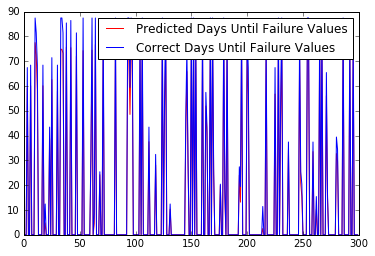

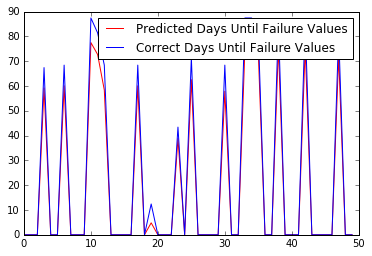

In [19]:
print("Score:")
print(score)

pyplot.plot(predicted, 'r-', label='Predicted Days Until Failure Values')
pyplot.plot(correct_values, 'b-', label='Correct Days Until Failure Values')
pyplot.legend()
pyplot.show()

pyplot.plot(predicted[0:50], 'r-', label='Predicted Days Until Failure Values')
pyplot.plot(correct_values[0:50], 'b-', label='Correct Days Until Failure Values')
pyplot.legend()
pyplot.show()